In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as gs
%matplotlib inline
plt.style.use('bmh')
from scipy import stats as ss
from scipy.stats import norm
import seaborn as sns
sns.set_style('dark')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [2]:
n = 300 # number of students
def grades(lower, upper, mean, std, n=n): # get an array of grades in a range and distribution parameters
    return [int(x) for x in (ss.truncnorm.rvs(((lower - mean) / std), ((upper - mean) / std), loc=mean, scale=std, size=n))]

### Gathering grades
#### Labs

In [3]:
Lab = dict()
for _ in range(1, 9):
    Lab[_] = grades(0, 10, 5, 5)
for key, item in Lab.items():
    print(f"Lab {key} -> {item[:10]}")

Lab 1 -> [4, 4, 7, 2, 7, 5, 2, 5, 2, 6]
Lab 2 -> [4, 2, 2, 5, 5, 3, 4, 6, 8, 8]
Lab 3 -> [6, 5, 4, 8, 5, 2, 4, 7, 4, 0]
Lab 4 -> [2, 9, 5, 8, 0, 9, 6, 3, 6, 8]
Lab 5 -> [1, 9, 4, 9, 4, 2, 3, 4, 7, 4]
Lab 6 -> [5, 0, 1, 4, 4, 1, 9, 9, 6, 7]
Lab 7 -> [0, 1, 2, 2, 7, 6, 1, 4, 3, 5]
Lab 8 -> [6, 5, 9, 0, 6, 4, 5, 4, 2, 3]


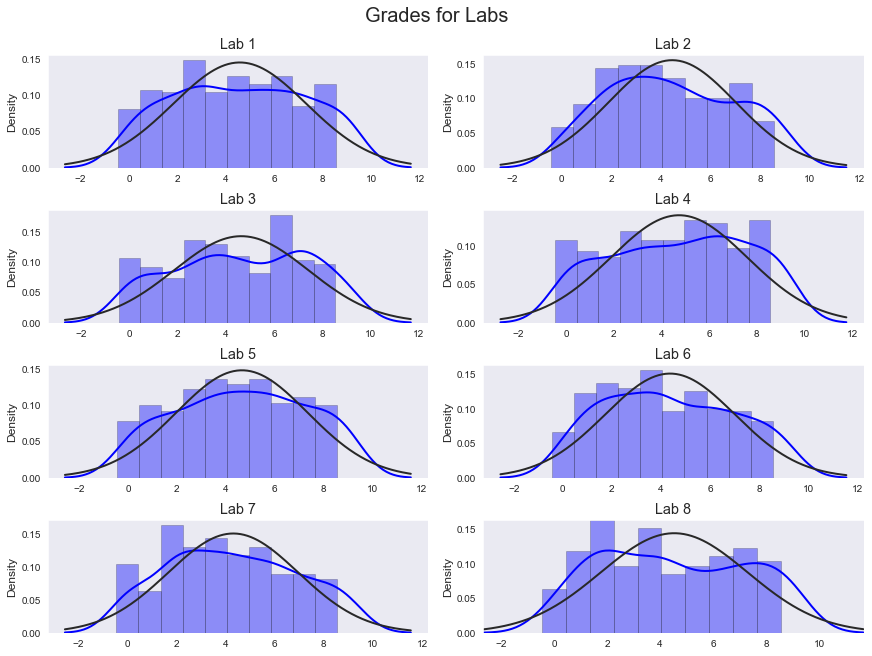

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(12, 9))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(8):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Lab[(_+1)], fit=norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=10)
    ax.set_title(f"Lab {_+1}")
fig.suptitle('Grades for Labs', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Assignments 

In [5]:
Assignment = dict()
for _ in range(1, 5):
    Assignment[_] = grades(0, 10, 5, 4)
for key, item in Assignment.items():
    print(f"Assignment {key} -> {item[:10]}")

Assignment 1 -> [1, 4, 5, 4, 9, 9, 2, 1, 3, 3]
Assignment 2 -> [3, 8, 6, 4, 8, 7, 8, 7, 6, 3]
Assignment 3 -> [4, 7, 7, 8, 8, 7, 1, 2, 3, 6]
Assignment 4 -> [2, 1, 5, 4, 7, 6, 7, 7, 5, 0]


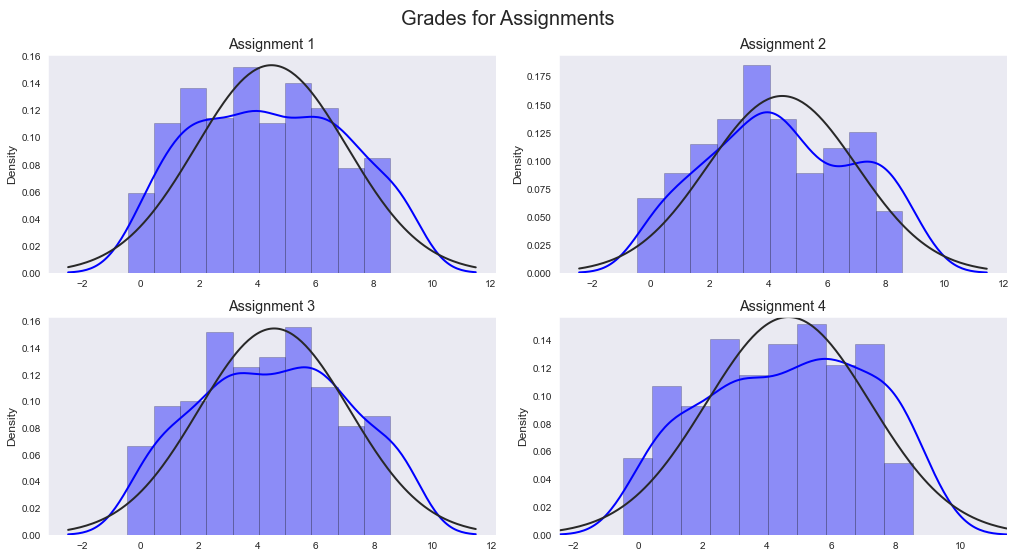

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(14, 14))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(4):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Assignment[(_+1)], fit=norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=10)
    ax.set_title(f"Assignment {_+1}")
fig.suptitle('Grades for Assignments', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Mid-Terms 

In [7]:
Mid_term = dict()
for _ in range(1, 3):
    Mid_term[_] = grades(0, 100, 50, 7)
for key, item in Mid_term.items():
    print(f"Mid-Term {key} -> {item[:10]}")

Mid-Term 1 -> [59, 50, 44, 36, 52, 51, 39, 61, 46, 56]
Mid-Term 2 -> [56, 54, 60, 63, 58, 51, 42, 49, 51, 48]


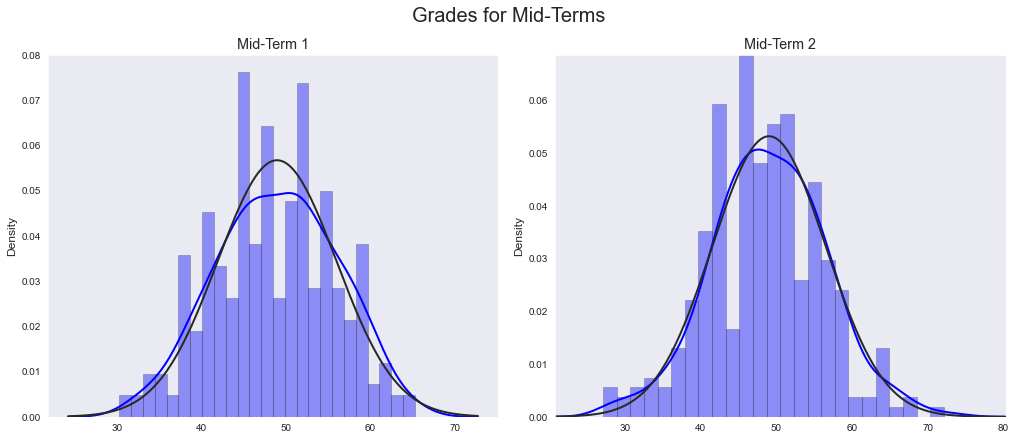

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(14, 6))
grid = gs(nrows=1, ncols=2, figure=fig)
for _ in range(2):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Mid_term[(_+1)], fit=norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=25)
    ax.set_title(f"Mid-Term {_+1}")
fig.suptitle('Grades for Mid-Terms', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Final Exam

In [9]:
Final = grades(0, 100, 65, 9)
print(f"Final Exam -> {Final[:10]}")

Final Exam -> [71, 77, 65, 61, 72, 59, 65, 63, 74, 58]


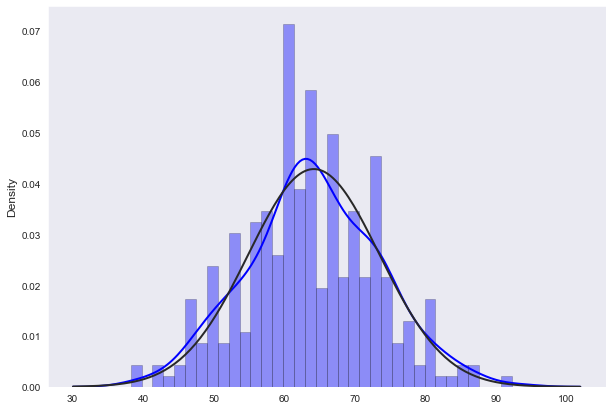

In [10]:
plt.figure(figsize=(10, 7))
sns.distplot(Final, fit=norm, norm_hist=True, color='blue', 
             hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=35)
plt.show()

### Grade Weights 
Each type of test will contribute this much to the final grade:
* Final Exam = 30%
* Mid-Terms = 30%
* Assignments = 20%
* Labs = 20%

Total passing percentage is assumed to be **60%**

### Making the DataFrame 
#### Combining the marks togethe

In [11]:
df = pd.DataFrame(index=range(1, n+1))
df.index.name = 'Student'

# automate the process of inputting the grades for all tests for each student
for _ in range(1, 9):
    df[f"Lab {_}"] = Lab[_]

for _ in range(1, 5):
    df[f"Assignment {_}"] = Assignment[_]
    
for _ in range(1, 3):
    df[f"Mid-Term {_}"] = Mid_term[_]
    
df['Final'] = Final
    
df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final
Student,,,,,,,,,,,,,,,
1,4,4,6,2,1,5,0,6,1,3,4,2,59,56,71
2,4,2,5,9,9,0,1,5,4,8,7,1,50,54,77
3,7,2,4,5,4,1,2,9,5,6,7,5,44,60,65
4,2,5,8,8,9,4,2,0,4,4,8,4,36,63,61
5,7,5,5,0,4,4,7,6,9,8,8,7,52,58,72


In [12]:
print(f"No. of students -> {len(df)}\nNumber of tests -> {df.shape[1]}")

No. of students -> 300
Number of tests -> 15


#### Determining if a student passes

In [13]:
Final_percent = 0.3
Mid_term_percent = 0.3
Assignments_percent = 0.2
Labs_percent = 0.2

Calculate the total grade for each category of test, then use that total and calculate the overall percentage of how much it contributes to students (based on the test's weightage) **overall** grade

In [14]:
lab_grades = list(df.iloc[:, :8].apply(lambda x: np.sum(x) / 80, axis=1) * Labs_percent)
assignment_grades = list(df.iloc[:, 8:12].apply(lambda x: np.sum(x) / 40, axis=1) * Assignments_percent)
mid_term_grades = list(df.iloc[:, 12:14].apply(lambda x: np.sum(x) / 200, axis=1) * Mid_term_percent)
final_grades = list(df.Final.apply(lambda x: (x / 100) * Final_percent))
lab_grades[:10]

[0.06999999999999999,
 0.08750000000000001,
 0.085,
 0.095,
 0.095,
 0.08000000000000002,
 0.085,
 0.10500000000000001,
 0.095,
 0.1025]

In [15]:
overall_grades = [] # calculate the total grade percentage
for _ in range(n):
    overall_grades.append(np.round((lab_grades[_] + assignment_grades[_] + mid_term_grades[_] + final_grades[_]) * 100, 2))
overall_grades[:10]

[50.55, 57.45, 55.1, 52.65, 63.6, 55.5, 49.15, 54.4, 54.75, 49.25]

#### Finishing the final table 

In [16]:
df['Total'] = overall_grades
df['Pass/Fail'] = ["Pass" if x >= 50 else "Fail" for x in overall_grades]
df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,4,4,6,2,1,5,0,6,1,3,4,2,59,56,71,50.55,Pass
2,4,2,5,9,9,0,1,5,4,8,7,1,50,54,77,57.45,Pass
3,7,2,4,5,4,1,2,9,5,6,7,5,44,60,65,55.10,Pass
4,2,5,8,8,9,4,2,0,4,4,8,4,36,63,61,52.65,Pass
5,7,5,5,0,4,4,7,6,9,8,8,7,52,58,72,63.60,Pass


In [17]:
df.describe().drop(['count', '25%', '50%', '75%'])

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total
mean,4.580000,4.450000,4.640000,4.736667,4.666667,4.363333,4.313333,4.530000,4.483333,4.476667,4.576667,4.670000,48.983333,49.016667,64.193333,52.131333
std,2.756009,2.573501,2.792201,2.864963,2.693152,2.649791,2.653039,2.775147,2.602364,2.533281,2.584516,2.550054,7.047597,7.516963,9.328416,4.284473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,28.000000,39.000000,38.800000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,66.000000,73.000000,93.000000,65.650000


### Creating excel file 

In [18]:
df.to_excel("Grades.xlsx", sheet_name='Grades')

### Making the model 
#### Preprocessing

In [19]:
df_rfc = df.copy()
df_linreg = df.copy()
df_rfc.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,4,4,6,2,1,5,0,6,1,3,4,2,59,56,71,50.55,Pass
2,4,2,5,9,9,0,1,5,4,8,7,1,50,54,77,57.45,Pass
3,7,2,4,5,4,1,2,9,5,6,7,5,44,60,65,55.10,Pass
4,2,5,8,8,9,4,2,0,4,4,8,4,36,63,61,52.65,Pass
5,7,5,5,0,4,4,7,6,9,8,8,7,52,58,72,63.60,Pass


##### RandomForestClassifier

In [20]:
df_rfc.drop(["Total", "Final"], inplace=True, axis=1)
df_rfc.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Pass/Fail
Student,,,,,,,,,,,,,,,
1,4,4,6,2,1,5,0,6,1,3,4,2,59,56,Pass
2,4,2,5,9,9,0,1,5,4,8,7,1,50,54,Pass
3,7,2,4,5,4,1,2,9,5,6,7,5,44,60,Pass
4,2,5,8,8,9,4,2,0,4,4,8,4,36,63,Pass
5,7,5,5,0,4,4,7,6,9,8,8,7,52,58,Pass


In [21]:
rfc_y = df_rfc["Pass/Fail"]
rfc_x = df_rfc.drop("Pass/Fail", axis=1)
rfc_x.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2
Student,,,,,,,,,,,,,,
1,4,4,6,2,1,5,0,6,1,3,4,2,59,56
2,4,2,5,9,9,0,1,5,4,8,7,1,50,54
3,7,2,4,5,4,1,2,9,5,6,7,5,44,60
4,2,5,8,8,9,4,2,0,4,4,8,4,36,63
5,7,5,5,0,4,4,7,6,9,8,8,7,52,58


In [22]:
rfc_x_scaled = StandardScaler().fit_transform(rfc_x)
rfc_y_encoder = LabelEncoder().fit(rfc_y)
rfc_y_encoded = rfc_y_encoder.transform(rfc_y)
rfc_x_scaled[0]

array([-0.21080087, -0.17515121,  0.48788472, -0.95681472, -1.3637528 ,
        0.24067196, -1.62852477,  0.53058681, -1.34076321, -0.58388067,
       -0.22349649, -1.04878605,  1.42366307,  0.93056213])

In [23]:
rfc_x_train, rfc_x_test, rfc_y_train, rfc_y_test = train_test_split(rfc_x_scaled, rfc_y_encoded,
                                                                    stratify=rfc_y_encoded, random_state=7, test_size=.15)
print(f"X train shape -> {rfc_x_train.shape}\ny train shape -> {rfc_y_train.shape}\
    \n\nX test shape -> {rfc_x_test.shape} \ny test shape -> {rfc_y_test.shape}")

X train shape -> (255, 14)
y train shape -> (255,)    

X test shape -> (45, 14) 
y test shape -> (45,)


In [24]:
rfc = RandomForestClassifier(n_estimators=700, warm_start=True,
                             random_state=7, n_jobs=-1).fit(rfc_x_train, rfc_y_train)
print(f"RandomForestClassifier score -> {rfc.score(rfc_x_test, rfc_y_test)}")

logreg = LogisticRegressionCV(cv=RepeatedStratifiedKFold(random_state=7), 
                              n_jobs=-1, random_state=7).fit(rfc_x_train, rfc_y_train)
print(f"LogisticRegressionCV score -> {logreg.score(rfc_x_test, rfc_y_test)}")

RandomForestClassifier score -> 0.7333333333333333
LogisticRegressionCV score -> 0.7555555555555555


In [25]:
svc = SVC(C=1, probability=True, random_state=7).fit(rfc_x_train, rfc_y_train)
print(f"SVC score -> {svc.score(rfc_x_test, rfc_y_test)}")

gnb = GaussianNB().partial_fit(rfc_x_train, rfc_y_train, np.unique(rfc_y_train))
print(f"GaussianNB score -> {gnb.score(rfc_x_test, rfc_y_test)}")

SVC score -> 0.7555555555555555
GaussianNB score -> 0.7111111111111111


In [26]:
knn = KNeighborsClassifier(n_neighbors=20).fit(rfc_x_train, rfc_y_train)
print(f"KNeighborsClassifier -> {knn.score(rfc_x_test, rfc_y_test)}")

KNeighborsClassifier -> 0.7111111111111111


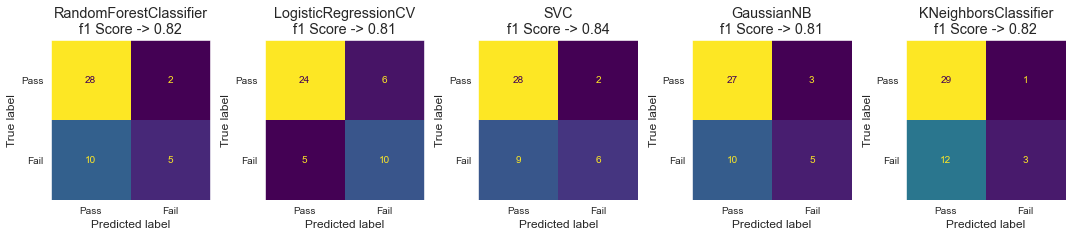

In [27]:
names = ["RandomForestClassifier", "LogisticRegressionCV", "SVC", "GaussianNB", "KNeighborsClassifier"]
models = [rfc, logreg, svc, gnb, knn]

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
grid = gs(nrows=1, ncols=5, figure=fig)
for _ in range(len(names)):
    ax = fig.add_subplot(grid[_])
    plot_confusion_matrix(models[_], rfc_x_test, rfc_y_test, labels=[1, 0], 
                          display_labels=["Pass", "Fail"], ax=ax, colorbar=False)
    ax.set_title(f"{names[_]}\nf1 Score -> {np.round(f1_score(rfc_y_test, models[_].predict(rfc_x_test)), 2)}")
plt.tight_layout()
plt.show()

### More coming soon  